#### 情報理工学系研究科　加藤真大

1975年から2019年までの日経225の時系列データをマルコフ・スイッチングモデルで分析する．
本稿は以下の5章からなる．
1. データの読み込み
2. モデルの説明
3. EM法による推定
4. MCMC法による推定
5. ARモデルとの組み合わせ
6. Hamilton (1989)

コードはgithubの[レポジトリ](https://github.com/MasaKat0/code-snippets/tree/master/markov-switching_model)に上げてある．

## 1. データの読み込み

日次の価格データnikkei225.csvを読み込み，月次のリターンデータに変換する．

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
daily_data = pd.read_csv('nikkei225.csv')
daily_data['date'] = pd.to_datetime(daily_data['date'], format='%Y-%m-%d')
daily_data = daily_data.set_index('date')
daily_data.head()

,value
date,
1949-05-16,176.21
1949-05-17,174.80
1949-05-18,172.53
1949-05-19,171.34
1949-05-20,169.20


日次の価格のデータを1975年から2019年までの月次のリターンのデータに変換する．

In [4]:
monthy_data = daily_data.resample(rule="M").last()
monthly_return_data = monthy_data.pct_change()
monthly_return_data = monthly_return_data[308:]

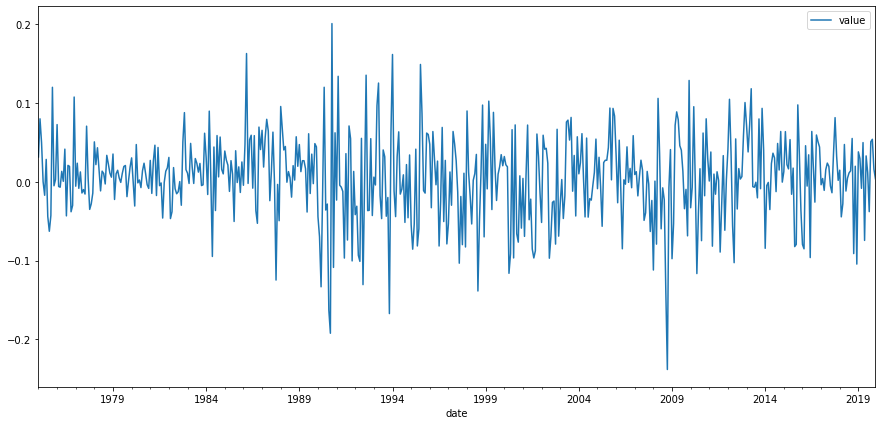

In [5]:
monthly_return_data.plot(figsize=(15, 7))

## 2. モデル

### 2.1 単純なレジーム・スイッチング・モデル
レジームの総数を$J$とする．$t$期の第$i$レジームのリターン$r^{(i)}(t)$とするとき，そのモデルを，
$$r^{(i)}(t)=\mu^{(i)}+\epsilon^{(i)}$$
とする．ここで，$\epsilon^{(i)}$は平均$0$，分散$(\sigma^2)^{(i)}$に従う正規分布である．

### 2.2 AR項を含むレジーム・スイッチング・モデル
さらに，このモデルにARモデルを組み合わせたモデルを
$$r^{(S_{t})}(t)=\mu^{(S_{t})} + \phi(r^{(S_{t-1})}(t-1) - \mu^{(S_{t-1})}) +\epsilon^{(S_{t})}$$
とする．ここで，$S_{t}$は第$t$期のレジームである．

### 2.3 マルコフ・スイッチング・モデル
レジームの推移確率にマルコフ性を仮定する．詳細は省略する．

## 3. EM法による推定

ライブラリstatsmodelsに含まれるマルコフ・スイッチング・モデルをEM法で推定する関数を用いて，上で紹介した単純なレジーム・スイッチング・モデルを推定する．

In [6]:
import statsmodels.api as sm

### 3.1 レジーム間で誤差項の分散が変わらない場合

はじめにレジーム間で誤差項の分散が変わらない場合のマルコフ・スイッチング・モデルを推定する．EM法による推定の結果，確率推移行列は以下のようになった．
$$P =
\begin{pmatrix}
0.50 & 0.50 \\\ 
0.50 & 0.50 \\
\end{pmatrix}
$$
これはあまり推定がうまくできなかった事例である．おそらくレジーム・スイッチの主要因が誤差項の分散であるために，このような結果になったのだと考察される．

In [7]:
model_equal_variance = sm.tsa.MarkovRegression(monthly_return_data, k_regimes=2, order=0, switching_variance=False)
result_em_equal_variance = model_equal_variance.fit()
result_em_equal_variance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  value   No. Observations:                  540
Model:               MarkovRegression   Log Likelihood                 809.335
Date:                Fri, 06 Dec 2019   AIC                          -1608.671
Time:                        15:21:58   BIC                          -1587.213
Sample:                    01-31-1975   HQIC                         -1600.279
                         - 12-31-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.203      0.022      0.982      -0.392       0.401
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0051      0.217      0.024      0.981      -0.420       0.431
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0029      0.000     16.427      0.000       0.003       0.003
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.4993    383.849      0.001      0.999    -751.831     752.830
p[1->0]        0.4992    363.669      0.001      0.999    -712.280     713.278
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

### 3.2 レジーム間で誤差項の分散が変わる場合（レジームの数は2個）

次にレジーム間で誤差項の分散が変わる場合のマルコフ・スイッチング・モデルを推定する．EM法による推定の結果，確率推移行列は以下のようになった．
$$P =
\begin{pmatrix}
0.94 & 0.06 \\\ 
0.04 & 0.96 \\\
\end{pmatrix}
$$
これは非常によくレジームを捉えることができた事例である．この後に，この推移確率に基づいてフィルター確率を図示する．

In [8]:
model_em_stochastic_variance = sm.tsa.MarkovRegression(monthly_return_data, k_regimes=2, order=0, switching_variance=True)
result_em_stochastic_variance = model_em_stochastic_variance.fit()
result_em_stochastic_variance.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  value   No. Observations:                  540
Model:               MarkovRegression   Log Likelihood                 848.280
Date:                Fri, 06 Dec 2019   AIC                          -1684.560
Time:                        15:21:59   BIC                          -1658.810
Sample:                    01-31-1975   HQIC                         -1674.489
                         - 12-31-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0123      0.002      5.575      0.000       0.008       0.017
sigma2         0.0008      0.000      6.415      0.000       0.001       0.001
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.004      0.088      0.930      -0.007       0.008
sigma2         0.0042      0.000     11.238      0.000       0.003       0.005
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9409      0.022     42.274      0.000       0.897       0.985
p[1->0]        0.0361      0.015      2.411      0.016       0.007       0.065
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

#### 3.2.1 フィルター確率の推移
授業で紹介されたようにレジーム1が高リターンの時期（バブル・アベノミクス）を表し，レジーム2が低リターン（失われた20年）の時期に対応する．また，上の推定結果と合わせて，レジーム1は高リターン低リスク，レジーム2は低リターン高リスクの時期になっていることが解釈できる．

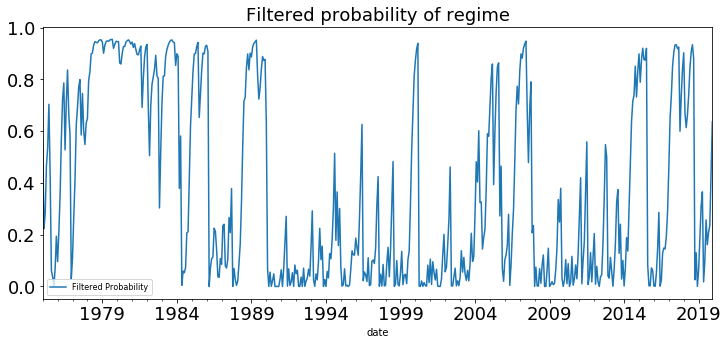

In [9]:
filtered_probability = monthly_return_data.copy()
filtered_probability['Filtered Probability'] = result_em_stochastic_variance.filtered_marginal_probabilities[0]

filtered_probability['Filtered Probability'].plot(figsize=(12,5), fontsize=12)
plt.title('Filtered probability of regime', fontsize=18)
plt.legend(fontsize=8)
plt.tick_params(labelsize=18)

#### 3.2.2 正規性の検定

レジームでクラスタリングした時系列の残差が，正規分布に従っているかどうかの検定を行う．

In [10]:
return_data = monthly_return_data['value'].values
filter_probability = result_em_stochastic_variance.filtered_marginal_probabilities[0]

return_data1 = return_data[filter_probability >= 0.5]
return_data2 = return_data[filter_probability < 0.5]

resideual1 = return_data1 - 0.0003
resideual2 = return_data2 - 0.0123

from scipy import stats

print('p-value regime1: ', stats.jarque_bera(resideual1)[0])
print('p-value regime2: ', stats.jarque_bera(resideual2)[1])

p-value regime1:  0.20631221446477127
p-value regime2:  0.2830906937057105


帰無仮説（正規分布であるという仮説）が棄却されないことが確認できる．一方で，レジームで分割していないreturn_dataに対してJarque-Bera検定を適用すると，

In [11]:
resideual = return_data - np.mean(return_data)
print('p-value whole data: ', stats.jarque_bera(resideual)[1])

p-value whole data:  1.1656342557841981e-11


帰無仮説が棄却されるので，正規性が満たされていないと判断できる．

### 3.3 レジーム間で誤差項の分散が変わる場合 （レジームの数は3個）

EM法の最後の実験として，レジームの数を3個に変えたものを試してみる．推定結果をみると，うまく収束していないことがわかる．

In [12]:
model_em_stochastic_variance = sm.tsa.MarkovRegression(monthly_return_data, k_regimes=3, order=1, switching_variance=True)
result_em_stochastic_variance = model_em_stochastic_variance.fit()
result_em_stochastic_variance.summary()

/Users/mkato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/mkato/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
/Users/mkato/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/mkato/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/Users/mkato/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                  value   No. Observations:                  540
Model:               MarkovRegression   Log Likelihood                 856.620
Date:                Fri, 06 Dec 2019   AIC                          -1689.241
Time:                        15:22:04   BIC                          -1637.742
Sample:                    01-31-1975   HQIC                         -1669.100
                         - 12-31-2019                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0121      0.003      4.772      0.000       0.007       0.017
sigma2         0.0006      0.000      4.934      0.000       0.000       0.001
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0098      0.006     -1.679      0.093      -0.021       0.002
sigma2         0.0047      0.001      7.830      0.000       0.004       0.006
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0145      0.006      2.486      0.013       0.003       0.026
sigma2         0.0026      0.000      5.601      0.000       0.002       0.003
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9297      0.034     27.372      0.000       0.863       0.996
p[1->0]      1.39e-13      0.043   3.26e-12      1.000      -0.083       0.083
p[2->0]        0.0597      0.040      1.493      0.136      -0.019       0.138
p[0->1]        0.0304      0.022      1.390      0.164      -0.012       0.073
p[1->1]        0.9741      0.015     65.562      0.000       0.945       1.003
p[2->1]     3.278e-08        nan        nan        nan         nan         nan
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

## 4. MCMC法による推定

ライブラリPyStanとStanで記述したベイズ・モデルを用いて，上で紹介した単純なレジーム・スイッチング・モデルを推定する．

In [13]:
import pystan

推定結果を表示するための関数を定義しておく．

In [29]:
def sampling_summary_to_df(fit4model):
    """
    :param StanFit4model fit4model:
    :return:
    """
    s = fit4model.summary()
    return pd.DataFrame(s["summary"], columns=s['summary_colnames'], index=s['summary_rownames'])

import seaborn as sns

#http://tekenuko.hatenablog.com/entry/2017/10/14/150405
def plot_MCMC(fit):
    # サンプル列を抽出
    la  = fit.extract(permuted=True)
    # パラメーター名
    names = fit.model_pars 
    # パラメーターの数
    n_param = np.sum([1 if len(x) == 0 else x[0] for x in fit.par_dims])

    # プロット
    f, axes = plt.subplots(n_param, 2, figsize=(12, 4*n_param))
    cnt = 0
    for name in names:
        dat = la[name]
        if dat.ndim == 2:
            for j in range(dat.shape[1]):
                d = dat[:,j]
                sns.distplot(d, hist=False, ax=axes[cnt, 0])
                sns.tsplot(d,   alpha=0.8, lw=.5, ax=axes[cnt, 1])
                cnt += 1
        else:
            # Intercept
            sns.distplot(dat, hist=False, ax=axes[cnt, 0])
            sns.tsplot(dat,   alpha=0.8, lw=.5, ax=axes[cnt, 1])
            cnt += 1

    name_list = []
    for name in names:
        dat = la[name]
        if la[name].ndim == 2:
            for i in range(dat.shape[1]):
                name_list.append("{}{}".format(name,i+1))
        else:
            name_list.append(name)

    for i in range(2):
        for j, t in enumerate(name_list):
            axes[j, i].set_title(t)
    plt.show()
    
def filter_prob(data, p0, p1, const0, const1, sigma20, sigma21):
    past_probs = np.array([[(1-p1)/(2-p0-p1), (1-p0)/(2-p0-p1)]]).T
    
    prob_list = []
            
    temp_array = np.array([0., 0.]).T
    
    for t in range(len(data)):
        temp_array[0] = (np.exp(-(data[t]-const0)**2/(2*sigma20))/np.sqrt(2*np.pi*sigma20))*past_probs[0]
        temp_array[1] = (np.exp(-(data[t]-const1)**2/(2*sigma21))/np.sqrt(2*np.pi*sigma21))*past_probs[1]
        
        denom = np.sum(temp_array)
                
        temp_array /= denom
        
        past_probs[0] = temp_array[0]*p0 + temp_array[1]*(1-p1);
        past_probs[1] = temp_array[0]*(1-p0) + temp_array[1]*p1;
        
        prob_list.append(past_probs[0][0])
        
    return prob_list

レジームは2個とし，その他推定に用いるデータをPyStanで扱うための形に整理しておく．

In [15]:
k_regimes = 2
return_data = monthly_return_data['value'].values
T = len(return_data)
dat = {'Y': return_data, 'T': T, 'k_regimes': k_regimes}

### 4.1 事前分布を一様分布にする場合

最初に全てのパラメータの事前分布を無事前情報の一様分布にして推定する．　まず，MCMCのモデルを定義した.stanファイルを読み込む．

In [16]:
with open('markov-switching_model.stan') as f:
    stm = pystan.StanModel(model_code=f.read())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7ca4512e69ee61abea9cc06801ac250f NOW.


パラメータをMCMC法で推定する．

In [17]:
n_itr = 5000
n_warmup = 1000
chains = 2

fit = stm.sampling(data=dat, iter=n_itr, chains=chains, n_jobs=-1, warmup=n_warmup, algorithm="NUTS", verbose=False)

結果を表示する．EM法とほぼ同じ結果が得られていることがわかる．EM法と比べると推移確率がより0もしくは1に近い値を取っている．

In [18]:
sampling_summary_to_df(fit).sort_values("Rhat", ascending=False)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
lp__,1169.764482,0.033686,1.876758,1165.185756,1168.773751,1170.117493,1171.141582,1172.338507,3103.981559,1.000509
sigma2_1,0.004648,0.000005,0.000455,0.003825,0.004333,0.004627,0.004931,0.005608,7024.872581,1.000335
const0,0.014975,0.000036,0.003542,0.007956,0.012672,0.014948,0.017370,0.021920,9639.183874,1.000306
const1,-0.005359,0.000054,0.005156,-0.015433,-0.008868,-0.005387,-0.001905,0.004748,9280.124308,1.000299
sigma2_0,0.001089,0.000002,0.000181,0.000780,0.000961,0.001072,0.001193,0.001507,7881.985355,1.000289
prob0,0.996331,0.000036,0.003702,0.986570,0.994948,0.997479,0.998946,0.999918,10570.979602,0.999962
prob1,0.996335,0.000040,0.003769,0.985887,0.994970,0.997473,0.999016,0.999925,8687.814683,0.999790


MCMCによるサンプリングの結果を表示する．よく収束していることがわかる．

/Users/mkato/opt/anaconda3/lib/python3.7/site-packages/seaborn/timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


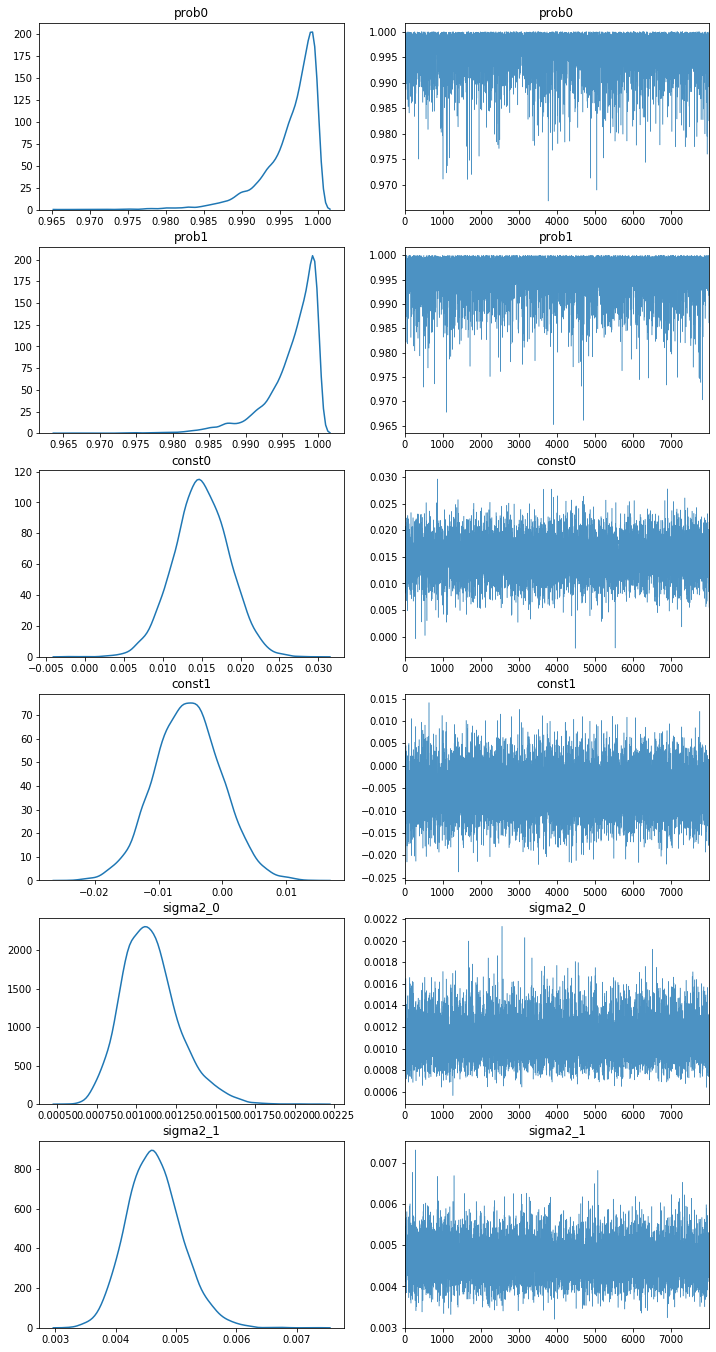

In [20]:
plot_MCMC(fit)

### 4.2 事前分布を適当に設定する場合
次に，バイアス項の事前分布に標準正規分布を，誤差高の分散の事前分布に逆ガンマ分布を用いた推定結果を表示する．

In [21]:
with open('markov-switching_model-prior_dist.stan') as f:
    stm = pystan.StanModel(model_code=f.read())

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bc372b62e06b41e93d676be2a9d9242b NOW.


In [22]:
n_itr = 5000
n_warmup = 1000
chains = 2

fit = stm.sampling(data=dat, iter=n_itr, chains=chains, n_jobs=-1, warmup=n_warmup, verbose=False)

以下に結果を表示する．ほぼEM法や事前分布を一様分布にしているMCMC法と変わらないことがわかる．事前分布を一様分布にしているMCMC法と変わらない理由は，サンプルサイズが十分に大きいことにあると考えられる．

In [23]:
sampling_summary_to_df(fit).sort_values("Rhat", ascending=False)

,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
const1,-0.005384,0.000054,0.005133,-0.015540,-0.008790,-0.005465,-0.001929,0.004720,8920.967034,1.000066
sigma2_0,0.001196,0.000002,0.000199,0.000868,0.001054,0.001175,0.001317,0.001640,7828.053001,0.999962
sigma2_1,0.004590,0.000006,0.000462,0.003769,0.004268,0.004556,0.004886,0.005561,6647.884087,0.999912
const0,0.014878,0.000037,0.003605,0.007786,0.012452,0.014844,0.017365,0.021965,9491.158863,0.999889
prob1,0.996274,0.000038,0.003783,0.986616,0.994825,0.997491,0.998938,0.999899,10103.886362,0.999887
prob0,0.996332,0.000039,0.003657,0.986572,0.995018,0.997403,0.998916,0.999898,8969.411803,0.999881
lp__,1176.436172,0.029733,1.791922,1172.168602,1175.449633,1176.781310,1177.753478,1178.943469,3632.020599,0.999815


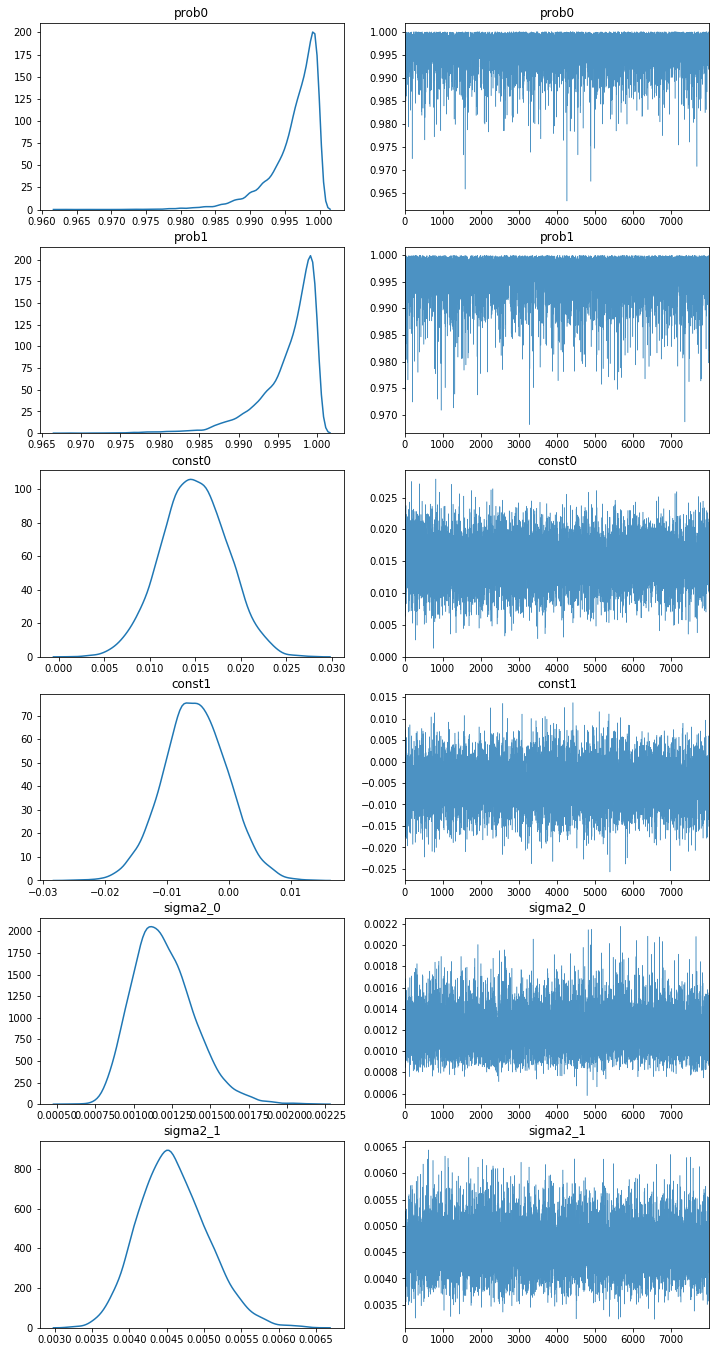

In [24]:
plot_MCMC(fit)

#### 4.2.1 フィルター化確率の表示

適当な事前分布を定めたMCMCによって得られた推定量に基づいて計算したフィルター化確率を，EM法によって推定したフィルター化確率と並べて表示する．この結果をみると，MCMC法の方がEM法よりもはっきりとレジームを捉えていることがわかる．

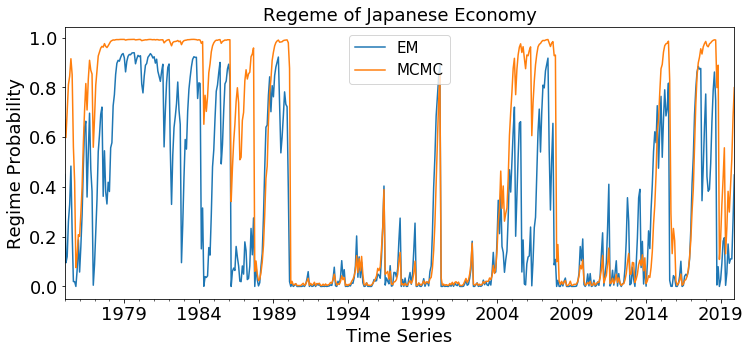

In [54]:
filtered_probability = monthly_return_data.copy()
filtered_probability['EM'] = result_em_stochastic_variance.filtered_marginal_probabilities[0]

results = sampling_summary_to_df(fit).sort_values("Rhat", ascending=False)
prob0 = results.loc['prob0']['mean']
prob1 = results.loc['prob0']['mean']
const0 = results.loc['const0']['mean']
const1 = results.loc['const1']['mean']
sigma0 = results.loc['sigma2_0']['mean']
sigma1 = results.loc['sigma2_1']['mean']

filtered_probability['MCMC'] = filter_prob(return_data, prob0, prob1, const0, const1, sigma0, sigma1)

filtered_probability.get(['EM', 'MCMC']).plot(figsize=(12,5), fontsize=13)
plt.title('Regeme of Japanese Economy', fontsize=18)
plt.xlabel('Time Series', fontsize=18)
plt.ylabel('Regime Probability', fontsize=18)
plt.legend(fontsize=15)
plt.tick_params(labelsize=18)

## 5. ARモデルとの組み合わせ
レジーム・スイッチング・モデルにARモデルを組み合わせたモデルを推定する．ARモデルのラグを増やすごとに，レジームの推移確率が0.5に近い値をとるようになっていくことがわかる．これはARモデルとレジーム・スイッチング・モデルの競合によるものであると思われる．

### 5.1 AR(1)モデルとの組み合わせ

In [80]:
model_em_stochastic_variance = sm.tsa.MarkovAutoregression(monthly_return_data, k_regimes=2, order=1, switching_variance=True)
result_em_stochastic_variance1 = model_em_stochastic_variance.fit()
result_em_stochastic_variance1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                    value   No. Observations:                  539
Model:             MarkovAutoregression   Log Likelihood                 847.129
Date:                  Fri, 06 Dec 2019   AIC                          -1678.259
Time:                          15:55:01   BIC                          -1643.941
Sample:                      01-31-1975   HQIC                         -1664.836
                           - 12-31-2019                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0122      0.002      6.003      0.000       0.008       0.016
sigma2         0.0008      0.000      6.508      0.000       0.001       0.001
ar.L1         -0.0877      0.083     -1.057      0.291      -0.250       0.075
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.004      0.053      0.958      -0.007       0.008
sigma2         0.0042      0.000     11.209      0.000       0.003       0.005
ar.L1          0.0405      0.057      0.715      0.474      -0.071       0.152
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9416      0.023     41.282      0.000       0.897       0.986
p[1->0]        0.0368      0.015      2.417      0.016       0.007       0.067
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

### 5.2 AR(2)モデルとの組み合わせ

In [81]:
model_em_stochastic_variance = sm.tsa.MarkovAutoregression(monthly_return_data, k_regimes=2, order=2, switching_variance=True)
result_em_stochastic_variance2 = model_em_stochastic_variance.fit()
result_em_stochastic_variance2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                    value   No. Observations:                  538
Model:             MarkovAutoregression   Log Likelihood                 846.132
Date:                  Fri, 06 Dec 2019   AIC                          -1672.264
Time:                          15:55:02   BIC                          -1629.385
Sample:                      01-31-1975   HQIC                         -1655.492
                           - 12-31-2019                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0121      0.002      5.906      0.000       0.008       0.016
sigma2         0.0008      0.000      6.352      0.000       0.001       0.001
ar.L1         -0.0828      0.083     -0.994      0.320      -0.246       0.080
ar.L2         -0.0255      0.084     -0.302      0.763      -0.191       0.140
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.004      0.081      0.935      -0.007       0.008
sigma2         0.0042      0.000     11.087      0.000       0.003       0.005
ar.L1          0.0400      0.058      0.690      0.490      -0.074       0.153
ar.L2         -0.0070      0.059     -0.118      0.906      -0.123       0.109
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9403      0.023     40.205      0.000       0.894       0.986
p[1->0]        0.0391      0.016      2.417      0.016       0.007       0.071
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

### 5.3 AR(3)モデルとの組み合わせ

In [82]:
model_em_stochastic_variance = sm.tsa.MarkovAutoregression(monthly_return_data, k_regimes=2, order=3, switching_variance=True)
result_em_stochastic_variance3 = model_em_stochastic_variance.fit()
result_em_stochastic_variance3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         Markov Switching Model Results                         
================================================================================
Dep. Variable:                    value   No. Observations:                  537
Model:             MarkovAutoregression   Log Likelihood                 841.211
Date:                  Fri, 06 Dec 2019   AIC                          -1658.423
Time:                          15:55:03   BIC                          -1606.991
Sample:                      01-31-1975   HQIC                         -1638.303
                           - 12-31-2019                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0193      0.003      5.556      0.000       0.012       0.026
sigma2         0.0012      0.000      5.776      0.000       0.001       0.002
ar.L1         -0.0797      0.066     -1.209      0.227      -0.209       0.049
ar.L2         -0.2160      0.065     -3.314      0.001      -0.344      -0.088
ar.L3         -0.2740      0.073     -3.740      0.000      -0.418      -0.130
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0082      0.005     -1.516      0.130      -0.019       0.002
sigma2         0.0030      0.000      6.458      0.000       0.002       0.004
ar.L1          0.3927      0.091      4.296      0.000       0.214       0.572
ar.L2          0.2060      0.088      2.333      0.020       0.033       0.379
ar.L3          0.4013      0.072      5.583      0.000       0.260       0.542
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.3390      0.131      2.582      0.010       0.082       0.596
p[1->0]        0.7489      0.090      8.347      0.000       0.573       0.925
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

### 5.4 フィルター化確率の表示
最後に以上の推定の結果得られるフィルター化確率をまとめて一つのグラフに表示する．かなり見づらいが，AR(3)モデルとの組み合わせの挙動が極めて不安定であることが理解できる．

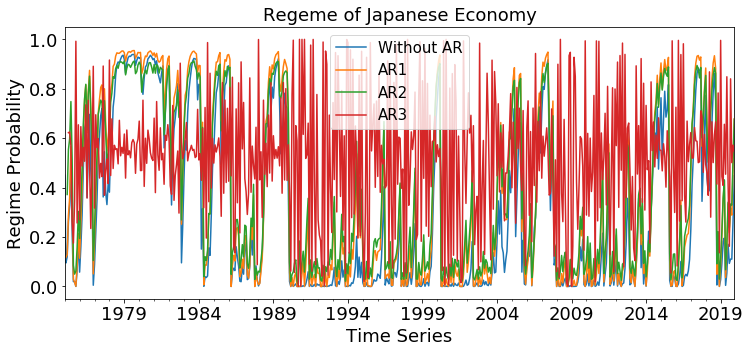

In [86]:
filtered_probability = monthly_return_data.copy()
filtered_probability['Without AR'] = result_em_stochastic_variance.filtered_marginal_probabilities[0]
filtered_probability['AR1'] = result_em_stochastic_variance1.filtered_marginal_probabilities[0]
filtered_probability['AR2'] = result_em_stochastic_variance2.filtered_marginal_probabilities[0]
filtered_probability['AR3'] = result_em_stochastic_variance3.filtered_marginal_probabilities[0]

filtered_probability.get(['Without AR', 'AR1', 'AR2', 'AR3']).plot(figsize=(12,5), fontsize=13)
plt.title('Regeme of Japanese Economy', fontsize=18)
plt.xlabel('Time Series', fontsize=18)
plt.ylabel('Regime Probability', fontsize=18)
plt.legend(fontsize=15)
plt.tick_params(labelsize=18)

## 6. Hamilton (1989)

最後に，Hamilton (1989)のモデルを簡単に紹介する．Hamilton (1989)の特徴は，アメリカのGNPの時系列に対して，三期間のARモデルと二つのレジームを組み合わせたモデルを推定していることにあり，またレジーム間で誤差項の分散が等しいことを仮定している．以下に
https://www.statsmodels.org/dev/examples/notebooks/generated/markov_autoregression.html
に記載されているコードと結果を表示する．

[Text(0.5, 1.0, 'Filtered probability of recession')]

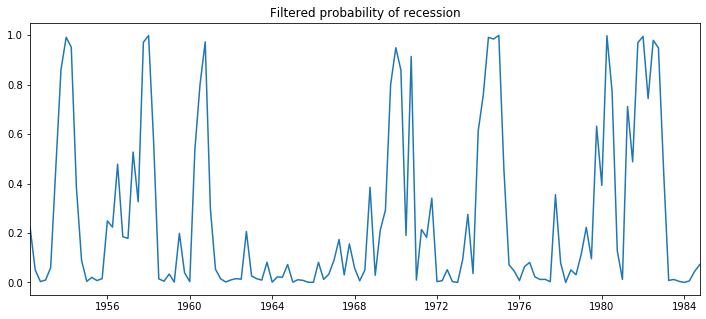

In [78]:
from pandas_datareader.data import DataReader
from datetime import datetime


# Get the RGNP data to replicate Hamilton
dta = pd.read_stata('https://www.stata-press.com/data/r14/rgnp.dta').iloc[1:]
dta.index = pd.DatetimeIndex(dta.date, freq='QS')
dta_hamilton = dta.rgnp

# Fit the model
mod_hamilton = sm.tsa.MarkovAutoregression(dta_hamilton, k_regimes=2, order=4, switching_ar=False)
res_hamilton = mod_hamilton.fit()

fig, ax = plt.subplots(1,figsize=(12,5))
ax.plot(res_hamilton.filtered_marginal_probabilities[0])
ax.set_xlim(dta_hamilton.index[4], dta_hamilton.index[-1])
ax.set(title='Filtered probability of recession')

おそらく分散がレジームの切り替えを特徴付けているために，等分散の仮定がレジームの切り替え確率を0.5付近にしていると考えられる．以下にHamilton (1989)を改良し，レジーム間で異なる分散を取れるようにしたモデルを推定する．

[Text(0.5, 1.0, 'Filtered probability of recession')]

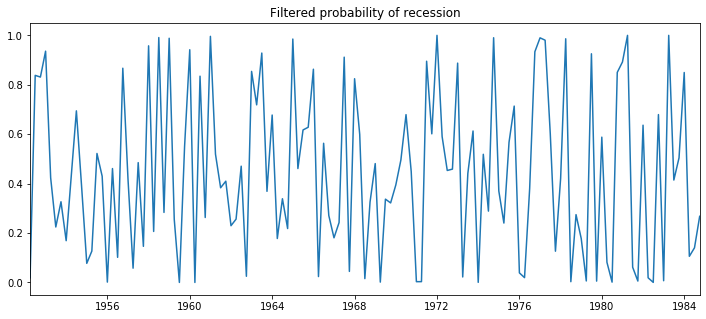

In [79]:
# Fit the model
mod_hamilton = sm.tsa.MarkovAutoregression(dta_hamilton, k_regimes=2, order=4, switching_variance=True)
res_hamilton = mod_hamilton.fit()

fig, ax = plt.subplots(1,figsize=(12,5))
ax.plot(res_hamilton.filtered_marginal_probabilities[0])
ax.set_xlim(dta_hamilton.index[4], dta_hamilton.index[-1])
ax.set(title='Filtered probability of recession')

期待した結果が得られなかった．相変わらずレジームは曖昧な挙動をしている．これはARモデルがスイッチング・モデルの推定に悪影響を及ぼしているものであると考えることができる．